In [22]:
import os
from pathlib import Path

project_root = "/content/ai-digital-toxicity-audit"

# If repo isn't here yet (fresh runtime), clone it
if not Path(project_root).exists():
    !git clone https://github.com/afreen-iws/ai-digital-toxicity-audit.git $project_root

%cd $project_root
print("Working directory:", os.getcwd())


/content/ai-digital-toxicity-audit
Working directory: /content/ai-digital-toxicity-audit


In [23]:
!pip install -r requirements.txt


In [24]:
import kagglehub
from pathlib import Path
import shutil

# Download with kagglehub
path = kagglehub.dataset_download("parthplc/facebook-hateful-meme-dataset")
print("Original Kaggle dataset path:", path)

# Copy into our project structure
source = Path(path)
target = Path("data/raw/hateful_memes")
target.mkdir(parents=True, exist_ok=True)

shutil.copytree(source, target, dirs_exist_ok=True)

print("Copied dataset to:", target)
!ls -R data/raw/hateful_memes


Using Colab cache for faster access to the 'facebook-hateful-meme-dataset' dataset.
Original Kaggle dataset path: /kaggle/input/facebook-hateful-meme-dataset
Copied dataset to: data/raw/hateful_memes
data/raw/hateful_memes:
data

data/raw/hateful_memes/data:
dev.jsonl  img	LICENSE.txt  README.md	test.jsonl  train.jsonl

data/raw/hateful_memes/data/img:
01235.png  14728.png  28764.png  42650.png  57183.png  71390.png  85209.png
01236.png  14765.png  28765.png  42653.png  57189.png  71392.png  85213.png
01243.png  14769.png  28790.png  42658.png  57193.png  71396.png  85237.png
01245.png  14782.png  28793.png  42673.png  57198.png  71398.png  85239.png
01247.png  14783.png  28905.png  42675.png  57203.png  71403.png  85243.png
01256.png  14789.png  28930.png  42681.png  57208.png  71428.png  85261.png
01258.png  14793.png  28935.png  42685.png  57209.png  71429.png  85269.png
01264.png  14802.png  28936.png  42687.png  57236.png  71430.png  85271.png
01268.png  14823.png  28945.png  4269

In [25]:
import json
import pandas as pd
from pathlib import Path

base_dir = Path("data/raw/hateful_memes")

# Find JSONL files
jsonl_files = list(base_dir.rglob("*.jsonl"))
print("Found JSONL files:")
for p in jsonl_files:
    print(" -", p)

# Pick train/dev by name
train_file = [p for p in jsonl_files if "train" in p.name.lower()][0]
dev_file   = [p for p in jsonl_files if "dev"   in p.name.lower()][0]

print("\nUsing:")
print("Train file:", train_file)
print("Dev file:  ", dev_file)

def load_jsonl(path: Path):
    rows = []
    with open(path, "r", encoding="utf-8") as f:
        for line in f:
            line = line.strip()
            if line:
                rows.append(json.loads(line))
    return rows

df_train = pd.DataFrame(load_jsonl(train_file))
df_val   = pd.DataFrame(load_jsonl(dev_file))

df_train.head(), df_val.head()


Found JSONL files:
 - data/raw/hateful_memes/data/test.jsonl
 - data/raw/hateful_memes/data/train.jsonl
 - data/raw/hateful_memes/data/dev.jsonl

Using:
Train file: data/raw/hateful_memes/data/train.jsonl
Dev file:   data/raw/hateful_memes/data/dev.jsonl


(      id            img  label  \
 0  42953  img/42953.png      0   
 1  23058  img/23058.png      0   
 2  13894  img/13894.png      0   
 3  37408  img/37408.png      0   
 4  82403  img/82403.png      0   
 
                                                 text  
 0   its their character not their color that matters  
 1  don't be afraid to love again everyone is not ...  
 2                           putting bows on your pet  
 3  i love everything and everybody! except for sq...  
 4  everybody loves chocolate chip cookies, even h...  ,
       id            img  label  \
 0   8291  img/08291.png      1   
 1  46971  img/46971.png      1   
 2   3745  img/03745.png      1   
 3  83745  img/83745.png      1   
 4  80243  img/80243.png      1   
 
                                                 text  
 0              white people is this a shooting range  
 1                              bravery at its finest  
 2  your order comes to $37.50 and your white priv...  
 3  it is time.

In [26]:
# Directory where image files live (the parent folder of JSONLs)
dataset_root = train_file.parent
print("Dataset root:", dataset_root)

def make_image_path(filename: str) -> str:
    filename = str(filename)
    # Some versions may store paths like 'img/12345.png' or just '12345.png'
    if filename.lower().endswith(".png"):
        return str(dataset_root / filename)
    else:
        return str(dataset_root / f"{filename}.png")

df_train["image_path"] = df_train["img"].apply(make_image_path)
df_val["image_path"]   = df_val["img"].apply(make_image_path)

# Keep only columns needed for multimodal model
df_train_mm = df_train[["text", "label", "image_path"]].dropna()
df_val_mm   = df_val[["text", "label", "image_path"]].dropna()

df_train_mm.head(), df_val_mm.head()


Dataset root: data/raw/hateful_memes/data


(                                                text  label  \
 0   its their character not their color that matters      0   
 1  don't be afraid to love again everyone is not ...      0   
 2                           putting bows on your pet      0   
 3  i love everything and everybody! except for sq...      0   
 4  everybody loves chocolate chip cookies, even h...      0   
 
                                   image_path  
 0  data/raw/hateful_memes/data/img/42953.png  
 1  data/raw/hateful_memes/data/img/23058.png  
 2  data/raw/hateful_memes/data/img/13894.png  
 3  data/raw/hateful_memes/data/img/37408.png  
 4  data/raw/hateful_memes/data/img/82403.png  ,
                                                 text  label  \
 0              white people is this a shooting range      1   
 1                              bravery at its finest      1   
 2  your order comes to $37.50 and your white priv...      1   
 3  it is time.. to send these parasites back to t...      1   
 4   

Label: Non-hateful (0)
Text: what would i do if she got pregnant
Image path: data/raw/hateful_memes/data/img/09324.png


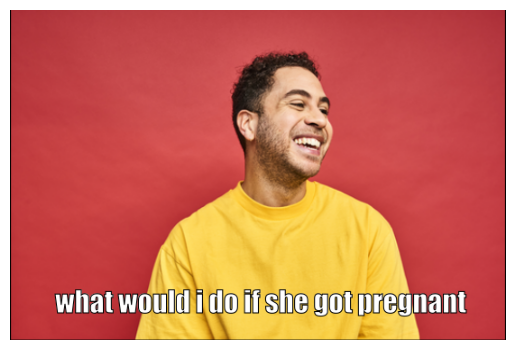

In [27]:
from PIL import Image
import matplotlib.pyplot as plt

row = df_train_mm.sample(1, random_state=0).iloc[0]

print("Label:", "Hateful (1)" if row["label"] == 1 else "Non-hateful (0)")
print("Text:", row["text"])
print("Image path:", row["image_path"])

img = Image.open(row["image_path"]).convert("RGB")
plt.imshow(img)
plt.axis("off");


In [28]:
from transformers import AutoTokenizer, ViTFeatureExtractor

text_model_name = "bert-base-uncased"
image_model_name = "google/vit-base-patch16-224-in21k"

tokenizer = AutoTokenizer.from_pretrained(text_model_name)
feature_extractor = ViTFeatureExtractor.from_pretrained(image_model_name)

print("Loaded tokenizer and feature extractor.")


Loaded tokenizer and feature extractor.


/usr/local/lib/python3.12/dist-packages/transformers/models/vit/feature_extraction_vit.py:30: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


In [29]:
import torch
from torch.utils.data import Dataset
from PIL import Image

class MultimodalDataset(Dataset):
    def __init__(self, df, tokenizer, feature_extractor):
        self.df = df.reset_index(drop=True)
        self.tokenizer = tokenizer
        self.feature_extractor = feature_extractor

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.loc[idx]

        # Process text
        text = str(row["text"])
        text_inputs = self.tokenizer(
            text,
            padding="max_length",
            truncation=True,
            max_length=128,
            return_tensors="pt"
        )

        # Process image
        img = Image.open(row["image_path"]).convert("RGB")
        img_inputs = self.feature_extractor(images=img, return_tensors="pt")

        # Prepare output
        item = {}
        item["input_ids"] = text_inputs["input_ids"].squeeze()
        item["attention_mask"] = text_inputs["attention_mask"].squeeze()
        item["pixel_values"] = img_inputs["pixel_values"].squeeze()
        item["labels"] = torch.tensor(int(row["label"]), dtype=torch.long)

        return item


In [30]:
train_ds_mm = MultimodalDataset(df_train_mm, tokenizer, feature_extractor)
val_ds_mm   = MultimodalDataset(df_val_mm, tokenizer, feature_extractor)

len(train_ds_mm), len(val_ds_mm)


(8500, 500)

In [31]:
sample = train_ds_mm[0]

for k, v in sample.items():
    print(k, type(v), v.shape)


input_ids <class 'torch.Tensor'> torch.Size([128])
attention_mask <class 'torch.Tensor'> torch.Size([128])
pixel_values <class 'torch.Tensor'> torch.Size([3, 224, 224])
labels <class 'torch.Tensor'> torch.Size([])


In [32]:
import torch
import torch.nn as nn
from transformers import BertModel, ViTModel


In [33]:
class MultimodalFusionModel(nn.Module):
    def __init__(self, text_model_name, image_model_name, num_labels=2):
        super().__init__()

        # Load pretrained BERT (text)
        self.text_model = BertModel.from_pretrained(text_model_name)

        # Load pretrained ViT (image)
        self.image_model = ViTModel.from_pretrained(image_model_name)

        # Get embedding dimensions
        text_hidden = self.text_model.config.hidden_size        # usually 768
        image_hidden = self.image_model.config.hidden_size      # usually 768

        # Fusion layer — concatenate features
        self.classifier = nn.Sequential(
            nn.Linear(text_hidden + image_hidden, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, num_labels)
        )

    def forward(self, input_ids, attention_mask, pixel_values, labels=None):
        # Text forward pass
        text_outputs = self.text_model(
            input_ids=input_ids,
            attention_mask=attention_mask
        )
        text_embeds = text_outputs.pooler_output  # (batch, 768)

        # Image forward pass
        image_outputs = self.image_model(pixel_values=pixel_values)
        image_embeds = image_outputs.pooler_output  # (batch, 768)

        # Late fusion: concatenate
        combined = torch.cat((text_embeds, image_embeds), dim=1)

        # Classify
        logits = self.classifier(combined)

        if labels is not None:
            loss_fn = nn.CrossEntropyLoss()
            loss = loss_fn(logits, labels)
            return {"loss": loss, "logits": logits}
        else:
            return {"logits": logits}


In [34]:
fusion_model = MultimodalFusionModel(text_model_name, image_model_name, num_labels=2)


In [35]:
!pip install evaluate


In [36]:
import evaluate
import numpy as np

accuracy = evaluate.load("accuracy")
f1 = evaluate.load("f1")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    return {
        "accuracy": accuracy.compute(predictions=preds, references=labels)["accuracy"],
        "f1": f1.compute(predictions=preds, references=labels, average="binary")["f1"],
    }


In [41]:
from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir="./models/checkpoints/multimodal_vit_bert",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=8,
    num_train_epochs=4,
    logging_steps=50,
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    greater_is_better=True,
    report_to="none"
)


In [42]:
from transformers import Trainer

trainer = Trainer(
    model=fusion_model,
    args=training_args,
    train_dataset=train_ds_mm,
    eval_dataset=val_ds_mm,
    compute_metrics=compute_metrics,
)


In [43]:
trainer.train()


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.496000,2.523563,0.534000,0.182456
2,0.589600,1.958150,0.564000,0.380682
3,0.103400,2.796227,0.590000,0.461942
4,0.038900,3.386489,0.586000,0.435967


TrainOutput(global_step=8500, training_loss=0.27687611363565223, metrics={'train_runtime': 1797.781, 'train_samples_per_second': 18.912, 'train_steps_per_second': 4.728, 'total_flos': 0.0, 'train_loss': 0.27687611363565223, 'epoch': 4.0})

In [44]:
eval_results = trainer.evaluate()
eval_results


{'eval_loss': 2.79622745513916,
 'eval_accuracy': 0.59,
 'eval_f1': 0.46194225721784776,
 'eval_runtime': 12.5817,
 'eval_samples_per_second': 39.74,
 'eval_steps_per_second': 5.007,
 'epoch': 4.0}

In [45]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix

# Get predictions on the multimodal validation set
pred_output = trainer.predict(val_ds_mm)
logits = pred_output.predictions
y_pred = np.argmax(logits, axis=-1)

# True labels from df_val_mm
y_true = df_val_mm["label"].values

print("Classification report (multimodal fusion):\n")
print(classification_report(y_true, y_pred, digits=4))

print("\nConfusion matrix:\n")
print(confusion_matrix(y_true, y_pred))


Classification report (multimodal fusion):

              precision    recall  f1-score   support

           0     0.5610    0.8280    0.6688       250
           1     0.6718    0.3520    0.4619       250

    accuracy                         0.5900       500
   macro avg     0.6164    0.5900    0.5654       500
weighted avg     0.6164    0.5900    0.5654       500


Confusion matrix:

[[207  43]
 [162  88]]


In [ ]:
save_dir = "./models/checkpoints/multimodal_vit_bert"

trainer.save_model(save_dir)           # saves fusion model weights
tokenizer.save_pretrained(save_dir)    # text tokenizer
feature_extractor.save_pretrained(save_dir)  # image preprocessor

print("Multimodal fusion model saved to:", save_dir)


In [46]:
save_dir = "./models/checkpoints/multimodal_vit_bert"

trainer.save_model(save_dir)           # saves fusion model weights
tokenizer.save_pretrained(save_dir)    # text tokenizer
feature_extractor.save_pretrained(save_dir)  # image preprocessor

print("Multimodal fusion model saved to:", save_dir)



Multimodal fusion model saved to: ./models/checkpoints/multimodal_vit_bert


In [54]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [53]:
from google.colab import files

files.download('/content/04_multimodal_fusion.ipynb')


FileNotFoundError: Cannot find file: /content/04_multimodal_fusion.ipynb